<a href="https://colab.research.google.com/github/nmningmei/MNE-python-BCBL-course/blob/master/1_1_Cross_Validation_an_EEG_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recap: what is our goal for our data?


## Frequentist goal: Prob(data | hypothesis)

P(data | hypothesis) $\propto$ P(hypothesis | data) $\cdot$ P(data)

In this view, P(data) is a uniform prior, in most of the cases, we assume the data is sampled from normal distribution. P(hypothesis | data) is the likelihood of the hypothesis, and it is often formulated in a binary decision bounded problem: $H_0$ and $H_a$.

Pros:
1. P(data | hypothesis) can be directly computed from tons of formulas
2. the statistics are often operated on the function of the sample of data -- 
$$t = \frac{\bar{X} - H_0}{\sqrt{var(X)/n}}$$

Cons:
1. we don't care P(data | hypothesis)
2. cannot be formulated in a predictive way -- I can tell you what does not happen (reject the $H_0$), but I cannot tell if something has happen ($H_a$ is true only if the $H_0$ is false)


## Bayesian goal: Prob(hypothesis | data)

P(hypothsis | data) $\propto$ P(data | hypothesis) $\cdot$ P(hypothesis)

In this view, P(hypothesis) is our prior, in the case of uncertainty, we assume it being an uniform distribution. P(data | hypothesis) is the likelihood of the data given a hypoethsis. This is often computed by model simulation. 

Pros:
1. we want to know P(hypothsis | data)
2. it is conceptually trackable
3. it is good for model selection, thus, we could compute the P(hypothesis | data) for multiple hypotheses

Cons:
1. P(hypothesis) is often hard to formulate
2. P(data | hypothesis) $\cdot$ P(hypothesis) is often not analytically trackable -- variational inference problem
3. it is often computational intense when we have lots of data due to the fact that this is an evidence-based hypothesis test

# What is cross validation?

## How likely is my machine learning model for new/future data? -- P(model | new data)

1. we fit a model with some data -- so, we have a model
2. we gather some new data
3. how accurate is my model for the new data?

Since the normal Bayesian approaches are often hard to track and compute, cross validation provides a trackable, quantitatively formulated, and easy to compute way of approximate P(hypothesis | data) or P(data | hypothesis/model). 

By splitting your data into train-validation-test, we could fit and validate a hypothsis/model using the train and validation data, which is equivalent to compute P(hypothesis/model). To compute the P(hypothesis | data), we reformulate the problem as "how likely is my machine learning model for new/future data". So, the model performance on the test data provides a numerical measure of P(model | test data).

How about P(data | hypothesis/model)? We could fit models that are generative, such as Gaussian Processes, a model that learns multivariate distributions from the training data so that we can sample new data from the model. 

## What kind of cross validation method should I use for my data?

As Jose said in the last meeting, we have so many cross validation method to choose from:

- data is Independent and Identically Distributed (i.i.d.) -- all samples stem from the same generative process and that the generative process is assumed to have no memory of past generated samples
1. [K-fold](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold)
2. [StratifiedKFold](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold)
3. [RepeatedKFold](https://scikit-learn.org/stable/modules/cross_validation.html#repeated-k-fold)

- IID and item-wise iteration
1. [LeaveOneOut](https://scikit-learn.org/stable/modules/cross_validation.html#leave-one-out-loo)
2. [LeavePOut](https://scikit-learn.org/stable/modules/cross_validation.html#leave-p-out-lpo)

- IID and permutation
1. [ShuffleSplit](https://scikit-learn.org/stable/modules/cross_validation.html#random-permutations-cross-validation-a-k-a-shuffle-split)
2. [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-shuffle-split)

- The i.i.d. assumption is broken if the underlying generative process yield groups of dependent samples. Such a grouping of data is domain specific. An example would be when there is medical data collected from multiple patients, with multiple samples taken from each patient. And such data is likely to be dependent on the individual group. In our example, the patient id for each sample will be its group identifier.
1. [GroupKFold](https://scikit-learn.org/stable/modules/cross_validation.html#group-k-fold)
2. [LeaveOneGroupOut](https://scikit-learn.org/stable/modules/cross_validation.html#leave-one-group-out)
3. [LeavePGroupsOut](https://scikit-learn.org/stable/modules/cross_validation.html#leave-p-groups-out)
4. [GroupShuffleSplit](https://scikit-learn.org/stable/modules/cross_validation.html#group-shuffle-split)

- customized splitting
1. [PredefinedSplit](https://scikit-learn.org/stable/modules/cross_validation.html#predefined-fold-splits-validation-sets)

StratifiedShuffleSplit and LeaveOneOut would fit to most of our data, because we usually don't have very specific hypotheses to test, so we just want to see if the pattern learned in the training set can be generalized to the testing set. 

So, in the spirit of combining the python meeting and MNE-python meeting, I will show an example of classifying 2 conditions of an EEG experiment

# MNE-python example

## Data: MEG

## Reference: [King & Dehaene](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5635958/)

In [3]:
!pip install mne

     |████████████████████████████████| 6.6MB 3.3MB/s 


In [12]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import mne
from mne import io
from mne.datasets import sample
from mne.stats import bonferroni_correction, fdr_correction

%matplotlib inline

import seaborn as sns
sns.set_context('talk')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import mne
from mne.datasets import sample 

# Preprocess data
data_path = sample.data_path()
# Load and filter data, set up epochs
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
events_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
raw = mne.io.read_raw_fif(raw_fname, preload=True)
picks = mne.pick_types(raw.info, meg=True, exclude='bads')  # Pick MEG channels
raw.filter(1., 30., fir_design='firwin')  # Band pass filtering signals
events = mne.read_events(events_fname)
event_id = {'Auditory/Left': 1, 'Auditory/Right': 2,
            'Visual/Left': 3, 'Visual/Right': 4}
tmin = -0.050
tmax = 0.400
# decimate to make the example faster to run, but then use verbose='error' in
# the Epochs constructor to suppress warning about decimation causing aliasing
decim = 2
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=tmin, tmax=tmax,
                    proj=True, picks=picks, baseline=None, preload=True,
                    reject=dict(mag=5e-12), decim=decim, verbose='error')

Using default location ~/mne_data for sample...
Creating ~/mne_data



Verifying hash 12b75d1cb7df9dfb4ad73ed82f61094f.
Decompressing the archive: /root/mne_data/MNE-sample-data-processed.tar.gz
(please be patient, this can take some time)
Successfully extracted to: ['/root/mne_data/MNE-sample-data']
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Opening raw data file /root/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window

## Let's visualize the data

In [5]:
epochs

<Epochs  |   287 events (all good), -0.0532787 - 0.39959 sec, baseline off, ~26.9 MB, data loaded,
 'Auditory/Left': 72
 'Auditory/Right': 72
 'Visual/Left': 73
 'Visual/Right': 70>

In [6]:
epochs.info

<Info | 14 non-empty values
 bads: []
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 203 GRAD, 102 MAG
 custom_ref_applied: False
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 file_id: 4 items (dict)
 highpass: 1.0 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 30.0 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 305
 projs: PCA-v1: on, PCA-v2: on, PCA-v3: on, Average EEG reference: on
 sfreq: 75.1 Hz
>

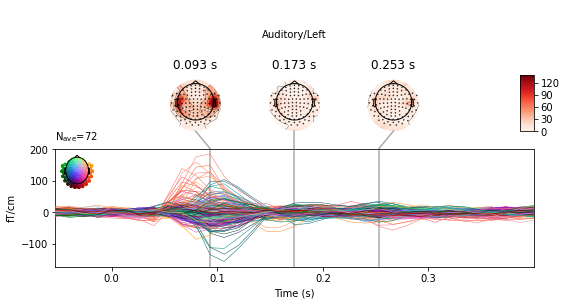

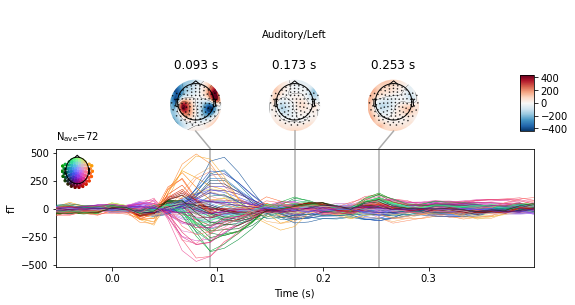

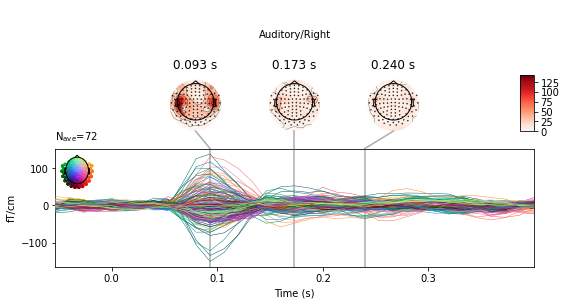

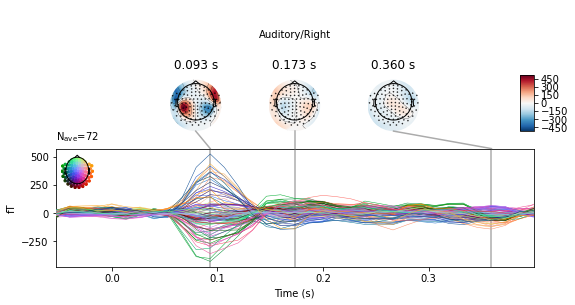

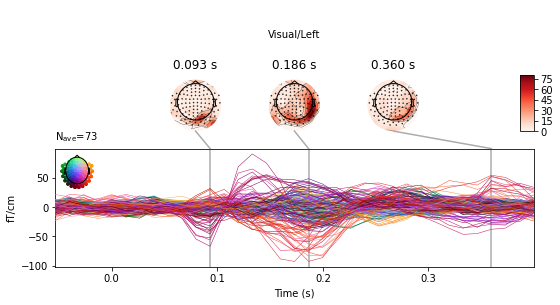

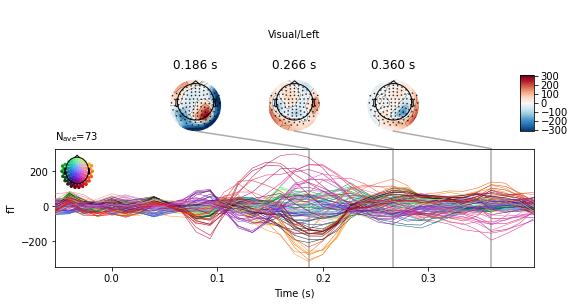

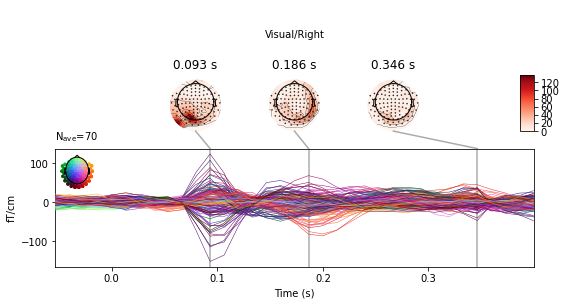

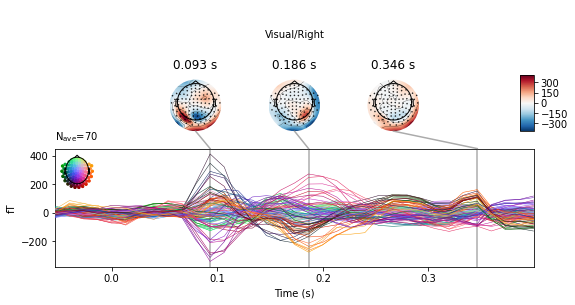

In [8]:
for event_name in epochs.event_id.keys():
    evoked = epochs[event_name].average()
    _=evoked.plot_joint(title = event_name)

## Univariate statistics based on one single channel

In [11]:
X = epochs.get_data()  # as 3D matrix
X = X[:, 0, :]  # take only one channel to get a 2D array
print(X.shape) # n_trial x n_time_points

(287, 35)


In [0]:
T, pval = stats.ttest_1samp(X, 0)
alpha = 0.05

n_samples, n_tests = X.shape
threshold_uncorrected = stats.t.ppf(1.0 - alpha, n_samples - 1)

reject_bonferroni, pval_bonferroni = bonferroni_correction(pval, alpha=alpha)
threshold_bonferroni = stats.t.ppf(1.0 - alpha / n_tests, n_samples - 1)

reject_fdr, pval_fdr = fdr_correction(pval, alpha=alpha, method='indep')
threshold_fdr = np.min(np.abs(T)[reject_fdr])

[Text(0, 0.5, 'T-stat'), Text(0.5, 0, 'Time (ms)')]

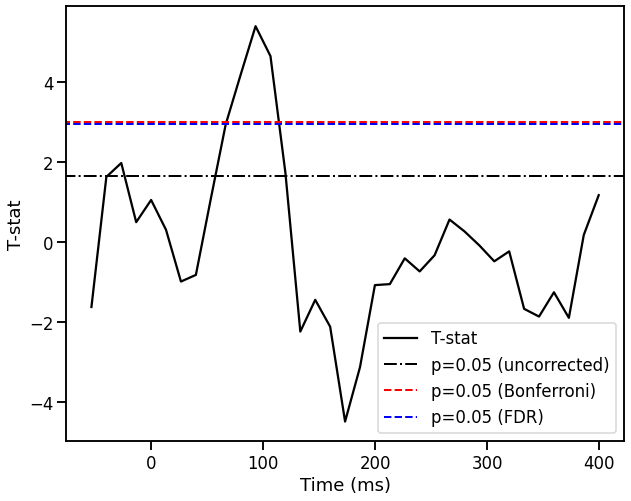

In [17]:
times = 1e3 * epochs.times

plt.close('all')
fig,ax = plt.subplots(figsize = (10,8))
ax.plot(times, T, 'k', label='T-stat')
xmin, xmax = times.min(),times.max()
ax.axhline(threshold_uncorrected, xmin, xmax, linestyle='-.', color='k',
           label='p=0.05 (uncorrected)', linewidth=2)
ax.axhline(threshold_bonferroni, xmin, xmax, linestyle='--', color='r',
           label='p=0.05 (Bonferroni)', linewidth=2)
ax.axhline(threshold_fdr, xmin, xmax, linestyle='--', color='b',
           label='p=0.05 (FDR)', linewidth=2)
ax.legend()
ax.set(xlabel="Time (ms)",ylabel="T-stat")

## Decoding: use all the information as features

1. epochs is a 3D matrix, n_samples x n_channels x n_time_points
2. scikit-learn models take 2D matrices as feature, so we need to reduce the dimensionality of the epochs matrix

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit,cross_validate

from collections import Counter

from mne.decoding import Vectorizer

In [25]:
clf = LogisticRegression(penalty = 'l2', # regularization type, L2 means to make the total sum of the weights as small as possible
                         dual = False,  # Dual formulation is only implemented for l2 penalty with liblinear solver. Prefer dual=False when n_samples > n_features.
                         tol = 1e-3, # stopping criteria
                         C = 1.,  # how much regularization adding to the fitting process
                         fit_intercept = False, # we will normalize the features so we don't need to fit the intercept
                         intercept_scaling = 1.,  # ??
                         class_weight = 'balanced', # just in case we don't have equal number of instance for the classes
                         random_state = 12345, # for reproducibility purpose
                         solver = 'lbfgs', # a fast optimizer
                         max_iter = int(1e3), # stopping criteria
                         multi_class = 'auto', # multi-class method, will talk about this later
                         verbose = 0, # print out the training process or not
                         warm_start = False, # before the fitting, we could use a small subset of the data to get to better initialization state for the fitting
                         n_jobs = 1, # multiprocess parallization
                         l1_ratio = None, # this is for elastic regularization, meaning we want to use both L1 and L2 
                         )
cv = StratifiedShuffleSplit(n_splits = 10,  # number of cross validation splits
                            test_size = .2,  # size of test set left out before fitting
                            random_state = 12345 # for reproducibility purpose
                            )
pipeline = make_pipeline(Vectorizer(),
                         StandardScaler(),
                         clf,
                         )
features_ = epochs.get_data()
targets_ = epochs.events[:,-1]

print(features_.shape,Counter(targets_))

(287, 305, 35) Counter({3: 73, 2: 72, 1: 72, 4: 70})


In [26]:
idx = targets < 3
features = features_[idx]
targets = targets_[idx]
print(features.shape, Counter(targets))

(144, 305, 35) Counter({2: 72, 1: 72})


In [29]:
res = cross_validate(estimator=pipeline, # the classifier/pipeline we defined above
                     X = features, # the 3D feature matrix. Since we have a vectorization procedure in our pipeline, we don't need to process our feature matrix
                     y = targets,  # the 1D vector of the labels
                     groups = None, # if we have a vector of group information, we can pass here and the cross validation method will take it into account
                     scoring = 'roc_auc', # if we don't define the scoring method, the default measure is "accuracy", which is never good
                     cv = cv, # simply replace any cross validation method you like here
                     n_jobs = -1,  # use all the possible CPUs for cross validation
                     verbose = 1,  # print out the cross validation computation process
                     fit_params = None,  # pass a dictionary here if you have only specific hyperparameters in the pipeline you want to fit but not all of them
                     pre_dispatch = '2*n_jobs', # related to n_jobs
                     return_train_score = False, # this is usually 100% because traditional machine learning models tend to overfit the training data
                     return_estimator = True, # return fit models from each cross validation fold
                     error_score = 'raise', # error message if the feature or target contain missing values
                     )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.7s finished


In [30]:
res['test_score']

array([0.77142857, 0.91904762, 0.91428571, 0.92380952, 0.88571429,
       0.78095238, 0.91428571, 0.93809524, 0.92380952, 0.84761905])

## How significant is this performance?

In [0]:
from sklearn.model_selection import permutation_test_score

In [32]:
score, permuted_scores, pval = permutation_test_score(estimator=pipeline,
                                                      X = features,
                                                      y = targets,
                                                      groups=None,
                                                      cv=cv,
                                                      n_permutations=100, # so the critical value is 0.01
                                                      n_jobs = -1,
                                                      random_state = 12345,
                                                      verbose = 1, 
                                                      scoring = 'roc_auc',
                                                      )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   35.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


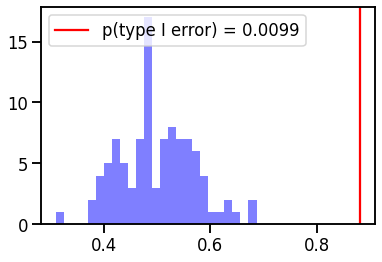

In [35]:
fig,ax = plt.subplots()
ax.hist(permuted_scores,bins = 25,color = 'blue',alpha = .5)
ax.axvline(res['test_score'].mean(),color = 'red',label = f'p(type I error) = {pval:.4f}')
ax.legend()

If want to know how to code permutation test in python: https://drive.google.com/open?id=1FZQ9sV96CjEEmQUYCXiVSF-TCBnKeYuB

## perform temporal decoding and temporal generalization altogether

When we look at M/EEG at the temporal axis, we fix a scale of single time point window to obtain the feature matrix that is 2D: n_sample x n_channels, thus, the features become the recordings at a given time point

1. temporal decoding: fit and test at the same time point
2. temporal generalization: fit at time point A and test at not only time point A but all other time points

In [0]:
from mne.decoding import (
                            SlidingEstimator, # for temporal decoding
                            cross_val_multiscore, # equivalent to cross_validate function
                            GeneralizingEstimator # for temporal generalization
                            )

In [42]:
pipeline = make_pipeline(#Vectorizer(), # because we will have 2D matricies at each time point, we don't need to dimension-reduce the matrices
                         StandardScaler(),
                         clf,
                         )
time_gen = GeneralizingEstimator(base_estimator = pipeline, 
                                 scoring = 'roc_auc', 
                                 n_jobs = -1,
                                 verbose = 1,
                                 )
scores_gen  = cross_val_multiscore(time_gen, 
                                   X = features,
                                   y = targets,
                                   groups = None,
                                   cv = cv, 
                                   n_jobs = -1,
                                   verbose = 1,
                                   )

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   23.8s remaining:    0.0s
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   23.8s finished


In [43]:
scores_gen.shape

(10, 35, 35)

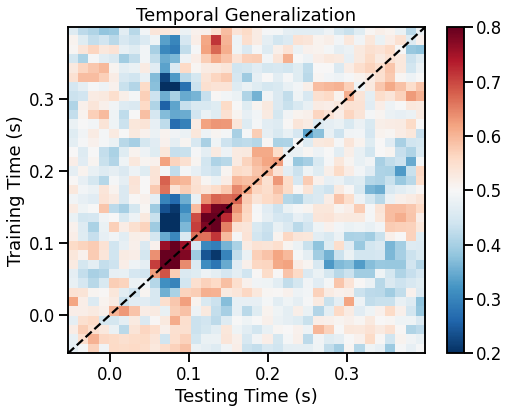

In [61]:
fig,ax = plt.subplots(figsize = (8,6),)
im = ax.imshow(scores_gen.mean(0),
               origin='lower',
               cmap = plt.cm.RdBu_r,
               vmin = .2,
               vmax = .8,
               aspect = 'auto',
               extent = [epochs.times.min(),
                         epochs.times.max(),
                         epochs.times.min(),
                         epochs.times.max()]
               )
cbar = plt.colorbar(im)
ax.set_xlabel('Testing Time (s)')
ax.set_ylabel('Training Time (s)')
ax.set_title('Temporal Generalization')
ax.plot([epochs.times.min(),epochs.times.max()],
        [epochs.times.min(),epochs.times.max()],
        linestyle = '--',
        color = 'black')

## we could perform cluster statistics on the matrix we have

In [0]:
from functools import partial

In [54]:
alpha           = 0.0001 # a very conservative alpha level
sigma           = 1e-3 # defining the width of the distribution of the t distribution we assume the scores follow
stat_fun_hat    = partial(mne.stats.ttest_1samp_no_p, sigma=sigma)
## perform nonparametric t test to find clusters in the conscious state
# compute the threshold for t statistics
t_threshold = stats.distributions.t.ppf(1 - alpha, scores_gen.shape[0] - 1) 
# apply the MNE python function of which I know less than nothing
threshold_tfce = dict(start=0, step=0.1) # threshold free clustering estimate
T_obs, clusters, cluster_p_values, H0   = clu \
            = mne.stats.permutation_cluster_1samp_test(
                    scores_gen - 0.5,
                    threshold           = threshold_tfce,
                    stat_fun            = stat_fun_hat,
                    tail                = 1, # find clusters that are greater than the chance level
                    seed                = 12345, # random seed
                    step_down_p         = 0.05,
                    buffer_size         = None, # stat_fun does not treat variables independently
                    n_jobs              = -1,
                    )

stat_fun(H1): min=-23.307250 max=58.229270
Running initial clustering
Using 583 thresholds from 0.00 to 58.20 for TFCE computation (h_power=2.00, e_power=0.50)
Found 1225 clusters
Permuting 1023 times (exact test)...



Computing cluster p-values
Step-down-in-jumps iteration #1 found 51 clusters to exclude from subsequent iterations
Permuting 1023 times (exact test)...



Computing cluster p-values
Step-down-in-jumps iteration #2 found 1 additional cluster to exclude from subsequent iterations
Permuting 1023 times (exact test)...



Computing cluster p-values
Step-down-in-jumps iteration #3 found 0 additional clusters to exclude from subsequent iterations
Done.


In [0]:
width = len(epochs.times)
p_clust = np.ones((width, width))# * np.nan
for c, p_val in zip(clusters, cluster_p_values):
    p_val_ = p_val.copy()
    if p_val_ > 0.05:
        p_val_ = 1.
    p_clust[c] = p_val_

In [0]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

[Text(0, 0.5, 'Train time'),
 Text(0.5, 0, 'Test time'),
 Text(0.5, 1.0, 'p value map')]

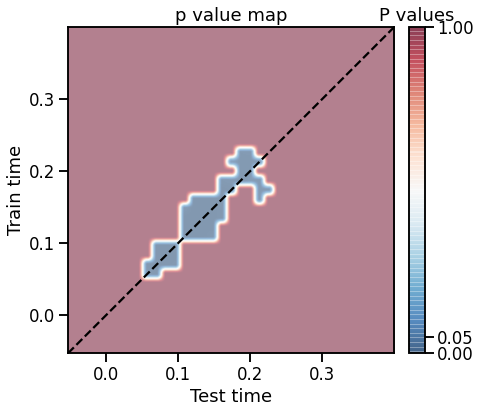

In [66]:
vmax = 1.
vmin = 0.
plt.close('all')
fig,ax = plt.subplots(figsize = (8,6))
im      = ax.imshow(p_clust,
                origin                   = 'lower',
                cmap                     = plt.cm.RdBu_r,# to emphasize the clusters
                extent                   = [epochs.times.min(),
                                            epochs.times.max(),
                                            epochs.times.min(),  
                                            epochs.times.max()],
                vmin                     = vmin,
                vmax                     = vmax,
                interpolation            = 'hanning',
                alpha                    = 0.5,
                )
ax.plot([epochs.times.min(),epochs.times.max()],
        [epochs.times.min(),epochs.times.max()],
        linestyle = '--',
        color = 'black')
# why do I specify the colorbar independently? Because the scale of the colorbar is not not uniform. 
divider = make_axes_locatable(ax)
cax     = divider.append_axes("right", 
                                size      = "5%", 
                                pad       = 0.2)
cb      = plt.colorbar(im, 
                        cax              = cax,
                        ticks            = [0,0.05,1])
cb.ax.set(title = 'P values')
ax.set(xlabel                           = 'Test time',
       ylabel                           = 'Train time',
       title                            = f'p value map')


# Conclusion

1. we have shown ax simple binary classification using a MEG data (n_sample x n_channels x n_time_points)
2. the cross validation method is chosen to be stratified random shuffling to initialize an uniform assumption of the data
3. the 10-folds cross validation shows statistical significant clusters of time points. In other words, these time points share similar patterns. 

Note:
1. you can try other cross validation methods and see how will it change the results
2. the interpretation of the cross validation method -- what do we generalize -- is more important than which model we use for classification. Logistic regression is one of the many classifiers. 
3. The data was downsampled to 75Hz prior to the all the analyses. 